<a href="https://colab.research.google.com/github/yuukis/shingenpy_doc_20250202/blob/main/20250202_Chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4. データ整形・分析・可視化

この Chapter では、Python の pandas を利用して、取得したデータの操作を行います。

## 4-1. pandas について

pandas は、Python でデータ分析やデータ操作を行うためのライブラリです。\
特に、表形式（表計算ソフトのようなデータ）や時系列データの処理に優れた機能を提供しており、データサイエンスや機械学習、業務データ処理など幅広い分野で利用されています。

### 4-1-1. pandas の主な特徴

* __データの読み書き__\
  CSV、Excel、JSON、SQL、Parquet など様々なフォーマットを扱える
* __データの操作・変換__\
  列や行の追加・削除・フィルタリング
* __グループ化や集計処理__\
  データのクレンジング（欠損値処理など）
* __統計・数値計算__\
  平均・中央値・分散・標準偏差などの統計計算が容易
* __データの可視化__\
  Matplotlib や Seaborn と組み合わせてグラフを描画可能
* __高速な処理__\
  NumPy ベースで最適化されており、大量データの処理も可能

### 4-1-2. pandas の主要データ構造

pandas には、主に以下の2つのデータ構造が存在します。

* __Series（1次元のデータ構造）__\
  1つの列を表すデータ構造で、インデックス（ラベル付き）を持つ1次元配列のように扱えます。
* __DataFrame（2次元のデータ構造）__\
  表形式のデータを扱うための構造で、行と列を持ちます。

### 4-1-3. よく使う操作

1. CSV ファイルの読み込み・書き出し
```python
df = pd.read_csv("data.csv")  # 読み込み
df.to_csv("output.csv", index=False)  # 書き出し
```
2. データの確認
```python
print(df.head())  # 先頭5行
print(df.tail())  # 末尾5行
print(df.info())  # データの情報
print(df.describe())  # 基本統計量
```
3. 列や行の選択
```python
print(df['名前'])  # 指定した列の取得
print(df.iloc[0])  # 指定した行の取得（行番号で指定）
print(df.loc[1])   # 指定した行の取得（インデックスで指定）
```
4. データのフィルタリング
```python
df_filtered = df[df['年齢'] > 28]  # 年齢が28以上の行を取得
```
5. データの並び替え
```python
df_sorted = df.sort_values('年齢', ascending=False)  # 年齢の降順でソート
```
6. グループ化と集計
```python
df_grouped = df.groupby('職業')['年齢'].mean()  # 職業ごとの平均年齢を計算
```

## 4-2. サンプルコード

### 4-2-1. データ整形①

In [1]:
# コード実行に必要なライブラリのインストール
!pip install python-dotenv pandas matplotlib

In [2]:
import os
import requests
import base64
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from IPython.display import display

# .envファイルから環境変数を読み込む
load_dotenv("api.env")
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

# アクセストークンを取得する関数
def get_token(client_id, client_secret):
  url = "https://idm.dataplatform-yamanashi.jp/auth/realms/Smartcity/protocol/openid-connect/token"
  payload = 'grant_type=client_credentials'
  b64encoded = base64.b64encode(f"{client_id}:{client_secret}".encode("utf-8"))
  authorization = f"Basic {b64encoded.decode('utf-8')}"
  headers = {
    'Authorization': authorization,
    'Content-Type': 'application/x-www-form-urlencoded',
  }
  response = requests.request("POST", url, headers=headers, data=payload)
  accesss_token = response.json()['access_token']

  return accesss_token

# APIからデータ取得する関数
def request_data(access_token, params=None):
  orion_url = "https://api.dataplatform-yamanashi.jp/ngsi/v2/entities"
  headers = {
    'Authorization': f"Bearer {access_token}"
  }
  try:
    # Send the GET request to the Orion Context Broker
    response = requests.get(orion_url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()
  except requests.exceptions.RequestException as e:
    print(f"Error fetching data from Orion Context Broker: {e}")
    return []

# データを DataFrame 形式に変更する関数
def convert_to_dataframe(data):
  try:
    # Extract relevant data (assuming the entities are in a list)
    entities = []
    for entity in data:
      # Flatten the attributes into a single dictionary per entity
      entity_data = {"id": entity.get("id"), "type": entity.get("type")}
      for key, value in entity.items():
        if key not in ["id", "type"]:
          # Handle attribute value (considering it's a structured object)
          entity_data[key] = value.get("value") if isinstance(value, dict) else value
      entities.append(entity_data)

    # Convert the list of entities to a DataFrame
    df = pd.DataFrame(entities)
    return df

  except requests.exceptions.RequestException as e:
    print(f"Error fetching data from Orion Context Broker: {e}")
    return pd.DataFrame()
  except ValueError as e:
    print(f"Error parsing JSON response: {e}")
    return pd.DataFrame()

In [20]:
# イベント情報
params = {
  "idPattern": ".*12354_event.*",
  "attrs": "event_name,end_date,description",    # 取得したい属性のみ指定
  "orderBy": "!end_date",    # 開催日で降順にソート
}

access_token = get_token(client_id, client_secret)
data = request_data(access_token, params)
# display(data)

df = convert_to_dataframe(data)
# display(df)

# DataFrame の特定の列のみ抽出する
df = df.loc[:,['event_name','end_date']]
display(df)

# csv に書き出し
df.to_csv("output.csv", index=False)

,event_name,end_date
0,山梨県立博物館庭園管理業務に係る一般競争入札について,2025-03-31
1,山梨県立博物館資料修復業務に係る一般競争入札公告について,2025-03-31
2,風土記の丘望見展「甲府市中道地区の縄文時代がけっこうすごい！」（県立考古博物館）,2025-03-30
3,山梨県埋蔵文化財センター主催「山梨の遺跡発掘展2025」（県立考古博物館）,2025-03-30
4,体験工房「ジュエリー制作体験」【山梨ジュエリーミュージアム】,"[2024-05-06, 2024-05-12, 2024-05-19, 2024-05-2..."
5,「美酒・美食王国やまなし」技術向上セミナーの開催について,2025-03-05
6,令和7年3月4日開催 山梨県主催合同就職フェア,2025-03-04
7,親子のものづくり教室「縄文風陶器づくりにチャレンジ」（県立考古博物館）,2025-03-02
8,思春期の子どもと向き合う保護者のためのセミナー【第6回】,2025-02-28
9,「中古住宅＋リノベ」で叶える理想の住まい。,2025-02-24


### 4-2-2. データ整形②

In [23]:
# 市町村別国調人口・世帯数(2020年)

params = {
    "idPattern": ".*EDAA02000.*",
    "type": "EDAA02000-2020-10-01",
    "limit": 100,
}

access_token = get_token(client_id, client_secret)
data = request_data(access_token, params)
# display(data)

df = convert_to_dataframe(data)
# display(df)

# area_name が空の行を除く
df = df[df['area_name'] != '']
# area_name total_number 列のみ抽出する
df = df.loc[:,['area_name','total_number']]
display(df)

,area_name,total_number
0,県合計,809974
1,市部計,691045
2,郡部計,118929
3,甲府市,189591
4,富士吉田市,46530
5,都留市,31016
6,山梨市,33435
7,大月市,22512
8,韮崎市,29067
9,南アルプス市,69459


### 4-2-3. グラフ表示

In [25]:
# 市町村別国調人口・世帯数(甲府市)

params = {
    "idPattern": ".*EDAA02000.*",
    "q": "area_name==甲府市",    # クエリ条件
    "orderBy": "acquisition_date",    # ソート項目
    "attrs": "acquisition_date,male,female,total_number",    # 取得したい属性のみ指定
    "limit": 100,
}

access_token = get_token(client_id, client_secret)
data = request_data(access_token, params)
# display(data)

df = convert_to_dataframe(data)
# display(df)

df['acquisition_date'] = pd.to_datetime(df['acquisition_date'])
df['year'] = df['acquisition_date'].dt.year
df = df.loc[:,['year','total_number']]
display(df)

,year,total_number
0,1920,88809
1,1925,103100
2,1930,117172
3,1935,123243
4,1940,122306
5,1947,125140
6,1950,139037
7,1955,154501
8,1960,160963
9,1965,172457


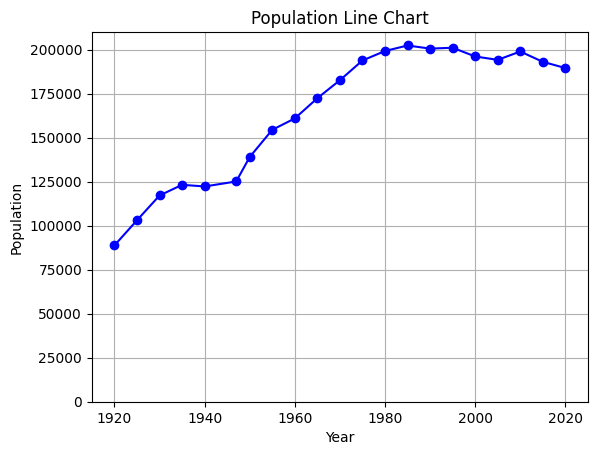

In [29]:
# 折れ線グラフで表示する
plt.plot(df["year"], df["total_number"], marker='o', linestyle='-', color='b')
plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Line Chart")
plt.ylim(0, 210000)
plt.grid(True)
plt.show()